In [ ]:
#imports

import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.metrics import precision_score
import nltk
import random
nltk.download('stopwords')

from nltk.corpus import stopwords
import string
stopset = stopwords.words('english') + list(string.punctuation)
nltk.download('punkt')
import re


import io

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!sudo apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [ ]:
#import train answer embeddings + all three clue sets for embeddings

drive.mount('/content/drive', force_remount=True)

train_clue_embed_df = pd.read_csv('/content/drive/MyDrive/berttrainclue.csv')
val_clue_embed_df = pd.read_csv('/content/drive/MyDrive/bertvalclue.csv')
test_clue_embed_df = pd.read_csv('/content/drive/MyDrive/berttestclue.csv')
answer_embed_df = pd.read_csv('/content/drive/MyDrive/berttrainanswer.csv')
train_clue_embed = np.array(train_clue_embed_df, order = 'c', dtype='float32')
val_clue_embed = np.array(val_clue_embed_df, order = 'c', dtype='float32')
test_clue_embed = np.array(test_clue_embed_df, order = 'c', dtype='float32')
answer_embed = np.array(answer_embed_df, order = 'c', dtype='float32')

Mounted at /content/drive


In [ ]:
#get train/val/test answers

nyt_train = pd.read_csv('/content/drive/MyDrive/nyttrain.csv')
nyt_val = pd.read_csv('/content/drive/MyDrive/nytval.csv')
nyt_test = pd.read_csv('/content/drive/MyDrive/nyttest.csv')

train_answers = np.array([k for j in [list(eval(i)) for i in nyt_train['answer']] for k in j])
val_answers = np.array([k for j in [list(eval(i)) for i in nyt_val['answer']] for k in j])
test_answers = np.array([k for j in [list(eval(i)) for i in nyt_test['answer']] for k in j])

In [ ]:
#import faiss, set up function

#set up L2 index to find k most similar answer embeddings for each clue, train/add train answer embeddings, calculate val/test recall

import faiss

def FAISS_metrics(embed_size, cells, k):
  quantizer = faiss.IndexFlatL2(embed_size)
  index = faiss.IndexIVFFlat(quantizer, embed_size, cells)
  index.train(answer_embed)
  index.add(answer_embed)
  val_D, val_I = index.search(val_clue_embed, k)
  del val_D
  val_recall = np.mean([bool(val_answers[i] in train_answers[val_I[i]]) for i in range(len(val_answers))])
  del val_I
  test_D, test_I = index.search(test_clue_embed, k)
  del test_D
  test_recall = np.mean([bool(test_answers[i] in train_answers[test_I[i]]) for i in range(len(test_answers))])
  del test_I
  return val_recall, test_recall

In [ ]:
#set up FAISS parameters, perform k recall for each k set to a multiple of 10

k_list = [int(i) for i in np.arange(10,1010,10)]
embed_size, cells = len(train_clue_embed[0]), 50
val_recall_list = []
test_recall_list = []

for i in k_list:
  print(i)
  val_recall, test_recall = FAISS_metrics(embed_size, cells, i)
  val_recall_list.append(val_recall)
  test_recall_list.append(test_recall)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000


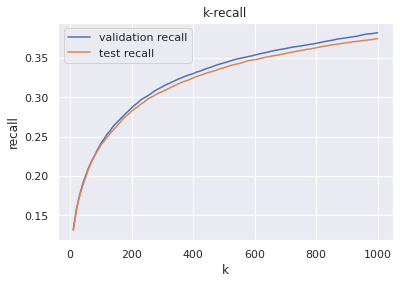

In [ ]:
#recall plot

plt.plot(k_list, val_recall_list, label='validation recall')
plt.plot(k_list, test_recall_list, label='test recall')
plt.xlabel('k')
plt.ylabel('recall')
plt.title('k-recall')
plt.legend()
plt.show()